Plots environments into a single graph, in order to be put on the paper.

In [3]:
import sys
sys.path.append('../.')

import pandas as pd
from environment import Environment
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# plt.rcParams.update({'font.size': 22})

def get_best_line(result_path):
    import os
    import json
    import argparse
    from constraints import ForwardConstraints
    from trainer import Trainer
    # print(os.getcwd())
    os.chdir('../')
    with open(os.path.join(result_path, "args.txt"), "r") as f:
        args_dict = json.loads(f.read())
    args = argparse.Namespace(**args_dict)
    environment = Environment(Path(f"./environments/{args.environment}"),
                              groups_file=args.groups_file,
                              reward_scaling_fn=args.cf_reward_scaling,
                              efficient_station_fn=args.cf_efficient_station,
                              station_density_fn=args.cf_station_density,
                              dmin=args.cf_dmin,
                              dmax=args.cf_dmax)
    constraints = ForwardConstraints(environment.grid_x_size, environment.grid_y_size, environment.existing_lines_full, environment.grid_to_vector)
    trainer = Trainer(environment, constraints, args)
    trainer.load_checkpoint(result_path)

    static = environment.static.to(device)
    dynamic = torch.zeros((1, args.dynamic_size, environment.grid_size)).float().to(device)
    trainer.actor.eval()
    tour_idx = trainer.actor(static, dynamic, args.station_num_lim, budget=args.budget,
                                                 line_unit_price=args.line_unit_price, station_price=args.station_price,
                                                 decoder_input=None, last_hh=None)
    os.chdir('environments')
    return tour_idx

In [4]:
xian = Environment(Path(f"./xian"))
diagonal = Environment((Path(f"./diagonal_5x5")))
dilemma = Environment(Path(f"./dilemma_5x5"))
diamond = Environment(Path(f"./diamond_5x5"))
amsterdam = Environment(Path(f"./amsterdam/"))

No groups file provided. Trying to use the default groups file.


/home/lo/anaconda3/envs/fair-nw-expansion-linux/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1650977166858/work/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


No groups file provided. Trying to use the default groups file.
No groups file provided. Trying to use the default groups file.
No groups file provided. Trying to use the default groups file.
No groups file provided. Trying to use the default groups file.


In [5]:
def calculate_agg_od(environment):
    """Calculate aggregate origin-destination flow matrix for each grid square of the given environment.

    Args:
        environment (Environment): environment for which to calcualte aggregate OD per grid square.

    Returns:
        torch.Tensor: aggregate od by grid
    """
    # 
    # A measure of importance of each square.
    agg_od_g = torch.zeros((environment.grid_x_size, environment.grid_y_size)).to(device)
    agg_od_v = environment.od_mx.sum(axis=1)
    # Get the grid indices.
    for i in range(agg_od_v.shape[0]):
        g = environment.vector_to_grid(torch.Tensor([i])).type(torch.int32)
        agg_od_g[g[0], g[1]] = agg_od_v[i]

    return agg_od_g

def calculate_price_groups(environment, bins):
    price_mx = environment.price_mx.clone().cpu().numpy()
    price_mx[price_mx <= 0] = np.nan
    bins = np.quantile(price_mx[~np.isnan(price_mx)], np.linspace(0, 1, bins + 1))[:-1]
    price_mx_binned = np.digitize(price_mx, bins).astype(np.float32)
    price_mx_binned[np.isnan(price_mx)] = np.nan

    return price_mx_binned

In [6]:
# Get aggregate ODs for each environment
xian_od = calculate_agg_od(xian).cpu()
diagonal_od = calculate_agg_od(diagonal).cpu()
dilemma_od = calculate_agg_od(dilemma).cpu()
diamond_od = calculate_agg_od(diamond).cpu()
ams_od = calculate_agg_od(amsterdam).cpu()

# Get the price groups for each environment
xian_groups = calculate_price_groups(xian, 5)
diagonal_groups = calculate_price_groups(diagonal, 3)
dilemma_groups = calculate_price_groups(dilemma, 5)
diamond_groups = calculate_price_groups(diamond, 5)
ams_groups = calculate_price_groups(amsterdam, 5)


/home/lo/git/fair-network-expansion/environments/.././environment.py:58: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  grid_x = (vector_idx // self.grid_y_size)


# Xian

/home/lo/git/fair-network-expansion/environments/.././environment.py:58: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  grid_x = (vector_idx // self.grid_y_size)
/tmp/ipykernel_28232/832445175.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


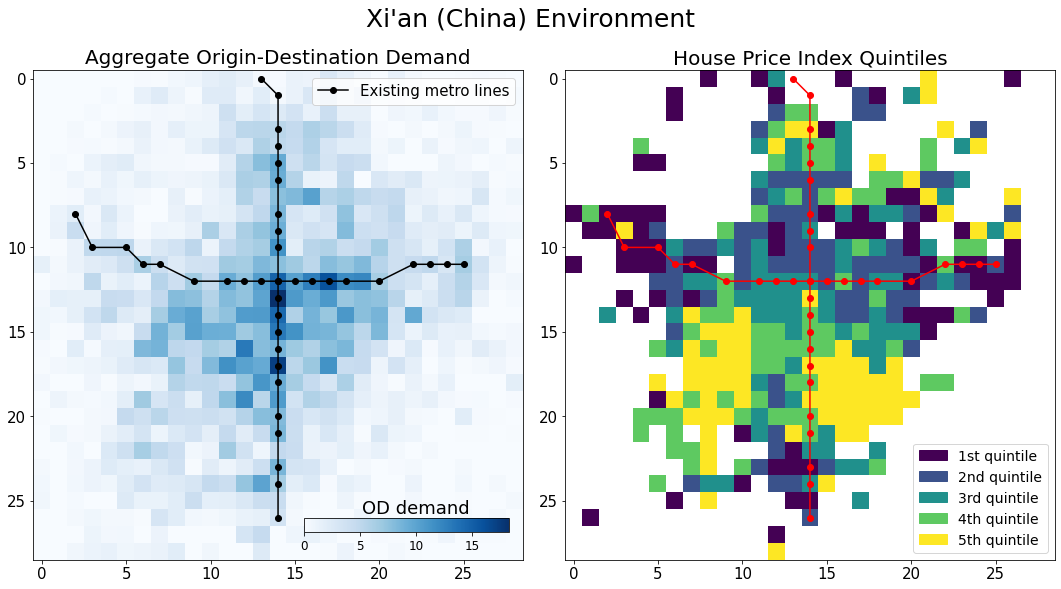

In [21]:
# def get_cax(ax):
#     divider = make_axes_locatable(ax)
#     return divider.append_axes('right', size='5%', pad=0.1)
plt.rc('font', size=15) 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(xian_od, cm.get_cmap('Blues'))
axs[0].set_title('Aggregate Origin-Destination Demand', fontsize=20)
cax = fig.add_axes([0.29, 0.17, 0.19, 0.02])
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal')
# cbar.set_label('test', horizontalalignment='right')
cax.text(5.2,1.3, 'OD demand', fontsize=18)
cax.tick_params(labelsize=12)

im1 = axs[1].imshow(xian_groups, cm.get_cmap('viridis'))
labels = ['1st quintile', '2nd quintile', '3rd quintile', '4th quintile', '5th quintile']
values = (np.unique(xian_groups[~np.isnan(xian_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
axs[1].set_title('House Price Index Quintiles', fontsize=20)
# fig.colorbar(im1, cax=get_cax(axs[1]), orientation='vertical')

for i, l in enumerate(xian.existing_lines):
    l_v = xian.vector_to_grid(l.T).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Existing metro lines"

    axs[0].plot(l_v[1], l_v[0], '-ok', label=label)
    axs[1].plot(l_v[1], l_v[0], '-or', label=label)

axs[0].legend()

fig.suptitle("Xi'an (China) Environment", y=0.9, fontsize=25)
fig.tight_layout()

## Xian MLP-ATT generated lines

tensor([[ 0.,  1.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 11., 12., 12., 12.,
         13., 13., 14., 14., 15., 15., 15., 15., 16., 17., 17., 18., 19., 19.,
         20., 21., 21., 22., 23., 23., 24., 25., 26., 27., 28., 28., 28., 28.,
         28., 28., 28.],
        [ 0.,  0.,  2.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  6.,  7.,
          7.,  8.,  8.,  9.,  9., 10., 11., 12., 12., 12., 13., 13., 13., 14.,
         14., 14., 15., 15., 15., 16., 16., 16., 16., 16., 16., 17., 18., 20.,
         22., 24., 25.]])
tensor([[10., 10., 11., 11., 11., 11., 11., 11., 11., 12., 12., 12., 12., 12.,
         13., 13., 13., 13., 13., 13., 14., 14., 14., 14., 14., 14., 15., 15.,
         16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 28.,
         28., 28., 28.],
        [28., 27., 27., 26., 25., 24., 23., 22., 21., 21., 20., 19., 18., 17.,
         17., 16., 15., 14., 13., 12., 12., 11., 10.,  9.,  8.,  7.,  7.,  6.,
          6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  

/tmp/ipykernel_4848/3279955934.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


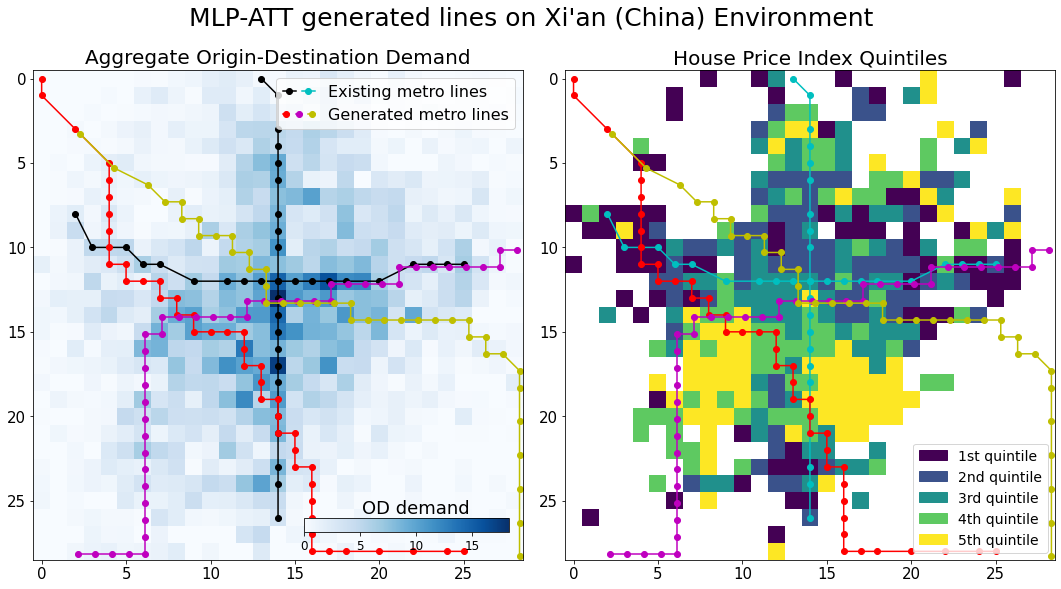

In [36]:
from matplotlib.legend_handler import HandlerTuple
plt.rc('font', size=15) 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(xian_od, cm.get_cmap('Blues'))
axs[0].set_title('Aggregate Origin-Destination Demand', fontsize=20)
cax = fig.add_axes([0.29, 0.17, 0.19, 0.02])
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal')
# cbar.set_label('test', horizontalalignment='right')
cax.text(5.2,1.3, 'OD demand', fontsize=18)
cax.tick_params(labelsize=12)

im1 = axs[1].imshow(xian_groups, cm.get_cmap('viridis'))
labels = ['1st quintile', '2nd quintile', '3rd quintile', '4th quintile', '5th quintile']
values = (np.unique(xian_groups[~np.isnan(xian_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
axs[1].set_title('House Price Index Quintiles', fontsize=20)
# fig.colorbar(im1, cax=get_cax(axs[1]), orientation='vertical')


# e_i = []
for i, l in enumerate(xian.existing_lines):
    l_v = xian.vector_to_grid(l.T).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Existing metro lines"

    e0, = axs[0].plot(l_v[1], l_v[0], '-ok', label=label)
    e1, =axs[1].plot(l_v[1], l_v[0], '-oc', label=label)

e_i = [e0, e1]

generated_lines = [torch.Tensor([[0,29,89,149,178,207,236,265,294,323,324,353,354,355,384,385,414,415,444,445,446,447,476,505,506,535,564,565,594,623,624,653,682,683,712,741,770,799,828,829,830,832,834,836,837]]),
                   torch.Tensor([[318,317,346,345,344,343,342,341,340,369,368,367,366,365,394,393,392,391,390,389,418,417,416,415,414,413,442,441,470,499,528,557,586,615,644,673,702,731,760,789,818,817,816,815,814]]),
                   torch.Tensor([[89,149,180,210,211,240,241,270,271,272,301,302,331,332,361,390,391,392,393,394,395,424,425,426,427,428,429,430,431,460,461,490,491,521,550,608,666,724,782,840]])]

colors = ['r', 'm', 'y']
g_i = []
shift = 0.15

for i, l in enumerate(generated_lines):
    l_v = xian.vector_to_grid(l).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Generated metro lines"
    print(l_v)

    p, = axs[0].plot(l_v[1] + i*shift, l_v[0] + i*shift, '-o'+colors[i], label=label)
    g_i.append(p)
    axs[1].plot(l_v[1] + i*shift, l_v[0] + i*shift, '-o'+colors[i], label=label)

axs[0].legend([(e_i[0], e_i[1]), (g_i[0], g_i[1], g_i[2])],["Existing metro lines", "Generated metro lines"],loc='upper right', fontsize=16,
               handler_map={tuple: HandlerTuple(ndivide=None)})

fig.suptitle("MLP-ATT generated lines on Xi'an (China) Environment", y=0.9, fontsize=25)
fig.tight_layout()

## Xian RNN-ATT generated lines

/home/lo/git/fair-network-expansion/environments/.././environment.py:58: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  grid_x = (vector_idx // self.grid_y_size)
/tmp/ipykernel_4848/1648869440.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


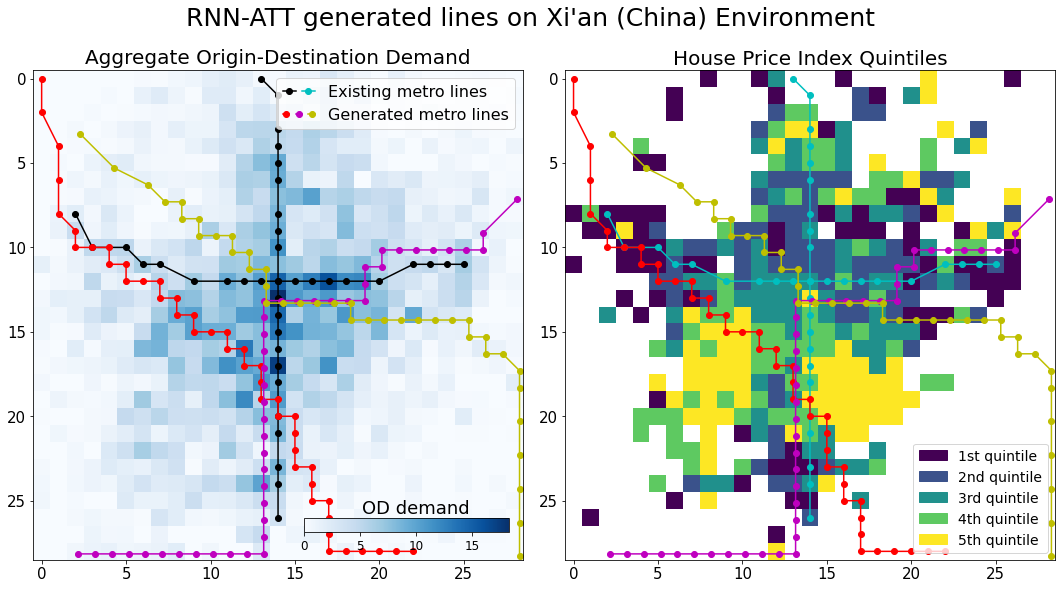

In [40]:
from matplotlib.legend_handler import HandlerTuple
plt.rc('font', size=15) 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(xian_od, cm.get_cmap('Blues'))
axs[0].set_title('Aggregate Origin-Destination Demand', fontsize=20)
cax = fig.add_axes([0.29, 0.17, 0.19, 0.02])
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal')
# cbar.set_label('test', horizontalalignment='right')
cax.text(5.2,1.3, 'OD demand', fontsize=18)
cax.tick_params(labelsize=12)

im1 = axs[1].imshow(xian_groups, cm.get_cmap('viridis'))
labels = ['1st quintile', '2nd quintile', '3rd quintile', '4th quintile', '5th quintile']
values = (np.unique(xian_groups[~np.isnan(xian_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
axs[1].set_title('House Price Index Quintiles', fontsize=20)
# fig.colorbar(im1, cax=get_cax(axs[1]), orientation='vertical')


# e_i = []
for i, l in enumerate(xian.existing_lines):
    l_v = xian.vector_to_grid(l.T).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Existing metro lines"

    e0, = axs[0].plot(l_v[1], l_v[0], '-ok', label=label)
    e1, =axs[1].plot(l_v[1], l_v[0], '-oc', label=label)

e_i = [e0, e1]

generated_lines = [torch.Tensor([[0,58,117,175,233,263,292,293,294,323,324,353,354,355,384,385,414,415,444,445,446,475,476,505,506,535,564,565,594,595,624,653,682,683,712,741,742,771,800,829,830,831,832,833,834]]),
                   torch.Tensor([[231,287,316,315,314,313,312,311,310,339,338,367,396,395,394,393,392,391,390,419,448,477,506,535,564,593,622,651,680,709,738,767,796,825,824,823,822,821,820,819,818,817,816,815,814]]),
                   torch.Tensor([[89,149,180,210,211,240,241,270,271,272,301,302,331,332,361,390,391,392,393,394,395,424,425,426,427,428,429,430,431,460,461,490,491,521,550,608,666,724,782,840]])]

colors = ['r', 'm', 'y']
g_i = []
shift = 0.15

for i, l in enumerate(generated_lines):
    l_v = xian.vector_to_grid(l).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Generated metro lines"

    p, = axs[0].plot(l_v[1] + i*shift, l_v[0] + i*shift, '-o'+colors[i], label=label)
    g_i.append(p)
    axs[1].plot(l_v[1] + i*shift, l_v[0] + i*shift, '-o'+colors[i], label=label)

axs[0].legend([(e_i[0], e_i[1]), (g_i[0], g_i[1], g_i[2])],["Existing metro lines", "Generated metro lines"],loc='upper right', fontsize=16,
               handler_map={tuple: HandlerTuple(ndivide=None)})

fig.suptitle("RNN-ATT generated lines on Xi'an (China) Environment", y=0.9, fontsize=25)
fig.tight_layout()

## Xian pointer generated lines

/tmp/ipykernel_4848/707968419.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


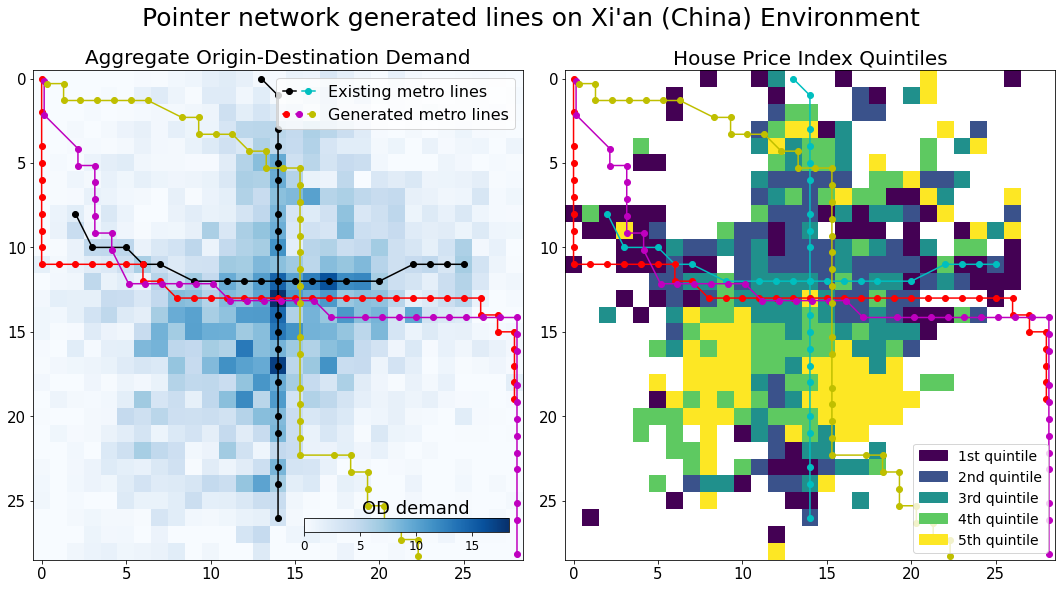

In [39]:
from matplotlib.legend_handler import HandlerTuple
plt.rc('font', size=15) 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(xian_od, cm.get_cmap('Blues'))
axs[0].set_title('Aggregate Origin-Destination Demand', fontsize=20)
cax = fig.add_axes([0.29, 0.17, 0.19, 0.02])
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal')
# cbar.set_label('test', horizontalalignment='right')
cax.text(5.2,1.3, 'OD demand', fontsize=18)
cax.tick_params(labelsize=12)

im1 = axs[1].imshow(xian_groups, cm.get_cmap('viridis'))
labels = ['1st quintile', '2nd quintile', '3rd quintile', '4th quintile', '5th quintile']
values = (np.unique(xian_groups[~np.isnan(xian_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
axs[1].set_title('House Price Index Quintiles', fontsize=20)
# fig.colorbar(im1, cax=get_cax(axs[1]), orientation='vertical')


# e_i = []
for i, l in enumerate(xian.existing_lines):
    l_v = xian.vector_to_grid(l.T).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Existing metro lines"

    e0, = axs[0].plot(l_v[1], l_v[0], '-ok', label=label)
    e1, =axs[1].plot(l_v[1], l_v[0], '-oc', label=label)

e_i = [e0, e1]

generated_lines = [torch.Tensor([[0,58,116,145,174,203,232,261,290,319,320,321,322,323,324,325,354,355,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,432,433,462,463,492,521,550,579]]),
                   torch.Tensor([[0,58,118,147,148,177,206,235,264,265,294,353,354,355,356,357,358,388,389,390,391,392,393,423,425,426,427,428,429,430,431,432,433,434,463,492,550,579,608,637,666,695,753,782,840]]),
                   torch.Tensor([[0,1,30,31,32,33,34,35,66,67,96,97,98,128,129,158,159,160,189,218,247,276,305,334,363,392,450,479,537,566,595,624,653,655,656,685,686,715,744,745,774,775,804,805,834]])]

colors = ['r', 'm', 'y']
g_i = []
shift = 0.15

for i, l in enumerate(generated_lines):
    l_v = xian.vector_to_grid(l).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Generated metro lines"

    p, = axs[0].plot(l_v[1] + i*shift, l_v[0] + i*shift, '-o'+colors[i], label=label)
    g_i.append(p)
    axs[1].plot(l_v[1] + i*shift, l_v[0] + i*shift, '-o'+colors[i], label=label)

axs[0].legend([(e_i[0], e_i[1]), (g_i[0], g_i[1], g_i[2])],["Existing metro lines", "Generated metro lines"],loc='upper right', fontsize=16,
               handler_map={tuple: HandlerTuple(ndivide=None)})

fig.suptitle("Pointer network generated lines on Xi'an (China) Environment", y=0.9, fontsize=25)
fig.tight_layout()

# Diagonal

/tmp/ipykernel_28232/3631120791.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


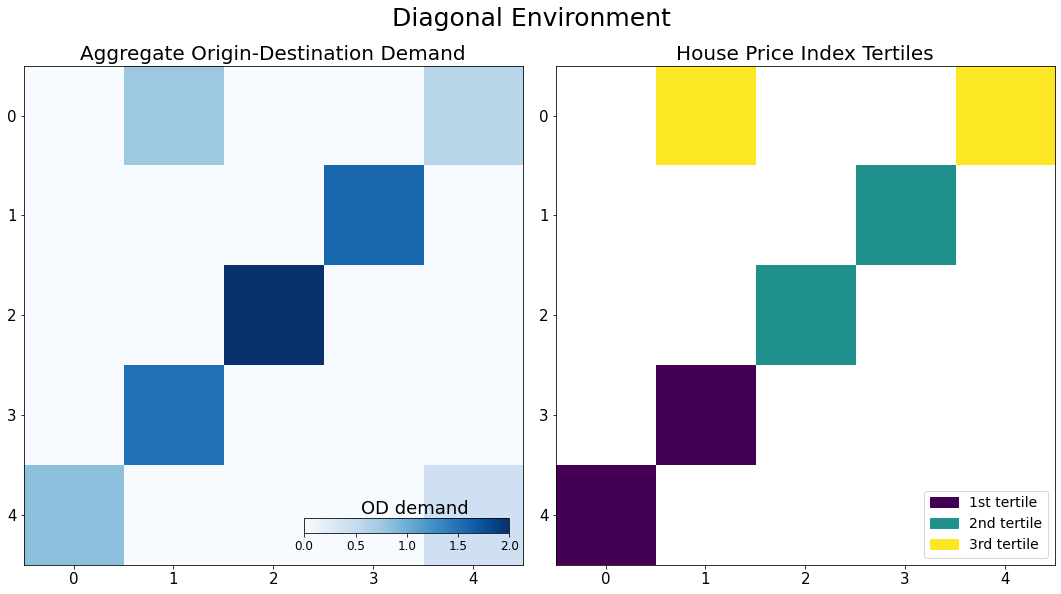

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(diagonal_od, cm.get_cmap('Blues'))
axs[0].set_title('Aggregate Origin-Destination Demand', fontsize=20)
cax = fig.add_axes([0.29, 0.17, 0.19, 0.02])
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal')
# cbar.set_label('test', horizontalalignment='right')
cax.text(0.55,1.3, 'OD demand', fontsize=18)
cax.tick_params(labelsize=12)

im1 = axs[1].imshow(diagonal_groups, cm.get_cmap('viridis'))
labels = ['1st tertile', '2nd tertile', '3rd tertile']
values = (np.unique(xian_groups[~np.isnan(xian_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
axs[1].set_title('House Price Index Tertiles', fontsize=20)

fig.suptitle("Diagonal Environment", y=0.9, fontsize=25)
fig.tight_layout()

# Dilemma

/tmp/ipykernel_25025/2075612106.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


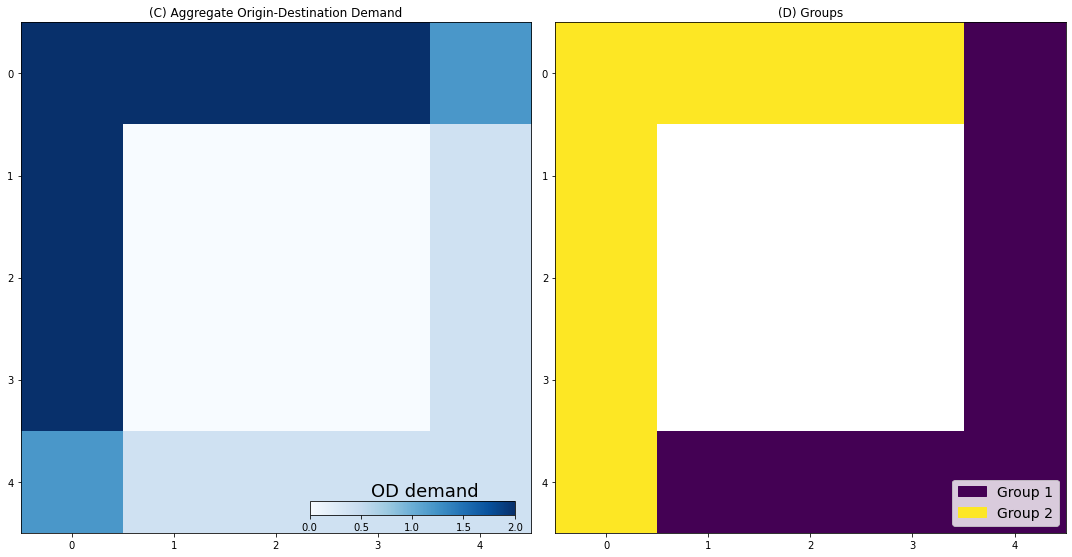

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(dilemma_od, cm.get_cmap('Blues'))
cax = fig.add_axes([0.29, 0.17, 0.19, 0.02])
fig.colorbar(im0, cax=cax, orientation='horizontal')
axs[0].set_title('(C) Aggregate Origin-Destination Demand')
cax.text(0.6,1.3, 'OD demand', fontsize=18)

im1 = axs[1].imshow(dilemma_groups, cm.get_cmap('viridis'))
labels = ['Group 1', 'Group 2']
values = (np.unique(dilemma_groups[~np.isnan(dilemma_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
axs[1].set_title('(D) Groups')

fig.tight_layout()

# Diamond

/tmp/ipykernel_28232/37185675.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


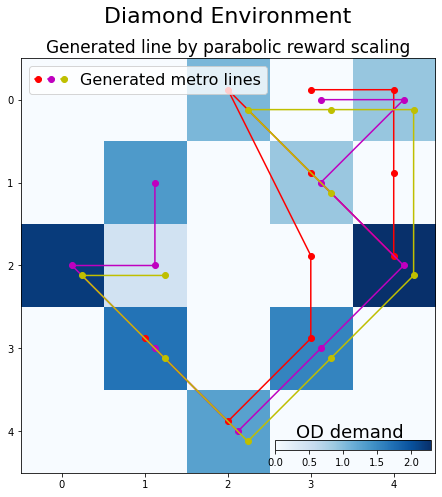

In [17]:
from matplotlib.legend_handler import HandlerTuple
fig, axs = plt.subplots(1, 1, figsize=(12, 7))

im0 = axs.imshow(diamond_od, cm.get_cmap('Blues'))
cax = fig.add_axes([0.555, 0.10, 0.18, 0.02])
fig.colorbar(im0, cax=cax, orientation='horizontal')
cax.text(0.3,1.3, 'OD demand', fontsize=18)

# im1 = axs[1].imshow(diamond_groups, cm.get_cmap('viridis'))
# labels = ['1st quintile', '2nd quintile', '3rd quintile', '4th quintile', '5th quintile']
# values = (np.unique(diamond_groups[~np.isnan(diamond_groups)]))
# colors = [ im1.cmap(im1.norm(value)) for value in values]
# patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
# axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
# axs[1].set_title('House Price Index Quintiles')

result_path = 'rewardfn_results/diamond_5x5_2022'
# Aggregate od flow
axs.set_title('Aggregate Origin-Destination Demand', fontsize=17)
# Generated lines
# forced constraints 
# axs.set_title('Generated line by enforced feasibility constraints', fontsize=17)
# fc_tour = torch.Tensor([[20, 21, 22, 17, 18, 19, 14, 9, 4]])
# linear scaling
# axs.set_title('Generated line by linear reward scaling', fontsize=17)
# generated_lines = [torch.Tensor([[9,4,14,8,2,6,3,7,13,1]]),
#                    torch.Tensor([[4,9,14,8,2,3,23,18,22,21]]),
#                    torch.Tensor([[5,6,11,10,16,22,18,14,4,9]])]

# parabolic scaling
axs.set_title('Generated line by parabolic reward scaling', fontsize=17)
generated_lines = [torch.Tensor([[3,4,9,14,8,2,13,18,22,16]]),
                   torch.Tensor([[6,11,10,16,22,18,14,8,4,3]]),
                   torch.Tensor([[11,10,16,22,18,14,4,3,2,8]])]


colors = ['r', 'm', 'y']
shift = 0.12
p_i = []

for i, tour in enumerate(generated_lines):

    tour_idx = diamond.vector_to_grid(tour)

    label = f"Generated metro line {i}"
    p, = axs.plot(tour_idx[1]+ i*shift, tour_idx[0] - shift + i*shift, '-o'+colors[i], label=label)
    p_i.append(p )

axs.legend([(p_i[0], p_i[1], p_i[2])],["Generated metro lines"],loc='upper left', fontsize=16,
               handler_map={tuple: HandlerTuple(ndivide=None)})
fig.suptitle("Diamond Environment", fontsize=22)
fig.tight_layout()

# Amsterdam

/tmp/ipykernel_25025/210312292.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


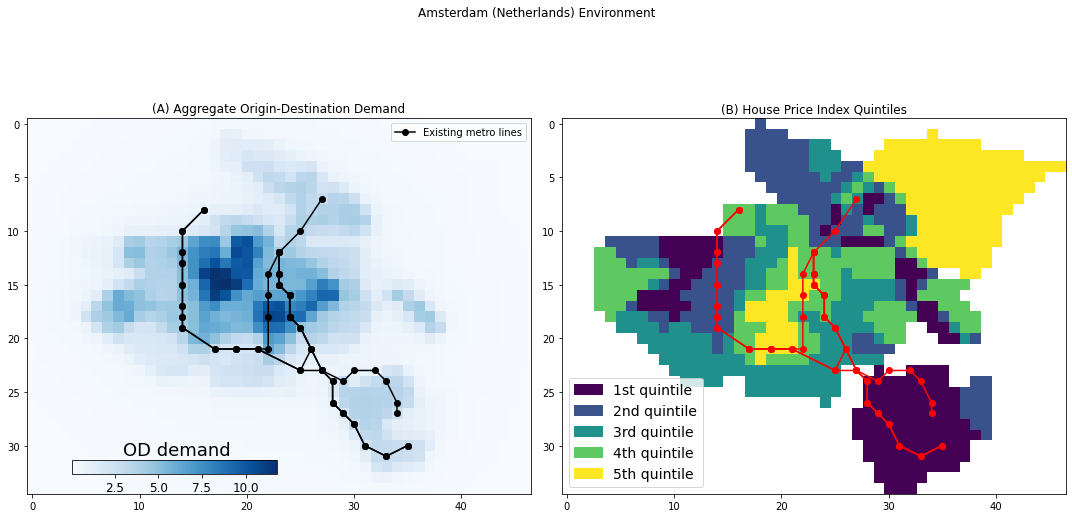

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(ams_od, cm.get_cmap('Blues'))
axs[0].set_title('(A) Aggregate Origin-Destination Demand')
cax = fig.add_axes([0.07, 0.25, 0.19, 0.02])
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal')
# cbar.set_label('test', horizontalalignment='right')
cax.text(3,1.3, 'OD demand', fontsize=18)
cax.tick_params(labelsize=12)

im1 = axs[1].imshow(ams_groups, cm.get_cmap('viridis'))
labels = ['1st quintile', '2nd quintile', '3rd quintile', '4th quintile', '5th quintile']
values = (np.unique(ams_groups[~np.isnan(ams_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower left", prop={'size': 14})
axs[1].set_title('(B) House Price Index Quintiles')
# fig.colorbar(im1, cax=get_cax(axs[1]), orientation='vertical')

for i, l in enumerate(amsterdam.existing_lines):
    l_v = amsterdam.vector_to_grid(l.T).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Existing metro lines"

    axs[0].plot(l_v[1], l_v[0], '-ok', label=label)
    axs[1].plot(l_v[1], l_v[0], '-or', label=label)

axs[0].legend()

fig.suptitle("Amsterdam (Netherlands) Environment", y=0.9)
fig.tight_layout()